In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
import cv2
from PIL import Image
import seaborn as sns
import time


import torch
import torch.nn as nn
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torchvision import transforms

In [2]:
# Set dataset paths
train_dir = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
valid_dir = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"


# Get list of classes (subdirectories in the 'train' directory)
classes = os.listdir(train_dir)
print(f"Classes found: {classes}")
print(f"Number of classes: {len(classes)}")

# Count images in each class
class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}

Classes found: ['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Leaf_M

In [3]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:

# Custom function to apply Gaussian blur and sharpening
def apply_filters(image):
    # Convert PIL image to OpenCV format
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # Apply Gaussian filtering
    image = cv2.GaussianBlur(image, (5, 5), 0)

    # Apply sharpening
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    image = cv2.filter2D(image, -1, kernel)

    # Convert back to PIL format
    image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    return image

# Update transformations with the custom filter function
train_transforms = transforms.Compose([
    transforms.Lambda(apply_filters),                   # Apply custom filters
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Lambda(apply_filters),                   # Apply custom filters
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [5]:
# Define the training and validation datasets
train_dataset = ImageFolder(root=train_dir, transform=train_transforms)
valid_dataset = ImageFolder(root=valid_dir, transform=valid_transforms)

# Update data loaders with optimal settings
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)

In [6]:

# Parameters to test
batch_sizes = [32]
# num_workers_options = [0, 2, 4, 8]
num_workers_options = [4]

# Test each combination
results = []
for batch_size in batch_sizes:
    for num_workers in num_workers_options:
        # Define data loader with current settings
        # loader = DataLoader(train_dir, batch_size=batch_size, num_workers=num_workers)
        loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)


        # Measure loading time for a small number of batches (e.g., 10)
        start_time = time.time()
        for i, (images, labels) in enumerate(loader):
            if i >= 10:  # Only load 10 batches to test speed
                break
        end_time = time.time()

        # Record the result
        time_taken = end_time - start_time
        results.append((batch_size, num_workers, time_taken))
        print(f"Batch size: {batch_size}, Num workers: {num_workers} -> Time: {time_taken:.4f} seconds")

# Find the best configuration
best_config = min(results, key=lambda x: x[2])
print(f"\nOptimal configuration - Batch size: {best_config[0]}, Num workers: {best_config[1]}, Time: {best_config[2]:.4f} seconds")


Batch size: 32, Num workers: 4 -> Time: 2.0260 seconds

Optimal configuration - Batch size: 32, Num workers: 4, Time: 2.0260 seconds


In [7]:
# Function to get predictions and labels for a model
def get_predictions_labels(model, data_loader):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, predicted_labels, model_name, class_names):
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(16, 14))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="crest", cbar=True, xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix for {model_name} Model")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()



In [9]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load the pre-trained VGG19 model
model_vgg19 = models.vgg19(pretrained=False)

# Modify the classifier for 38 classes
num_features = model_vgg19.classifier[-1].in_features
model_vgg19.classifier[-1] = nn.Linear(num_features, 38)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vgg19 = model_vgg19.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [10]:
import torch
import torch.nn as nn
from tqdm import tqdm  # Import tqdm for progress bar

# Define loss function and optimizer for VGG19
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_vgg19.parameters(), lr=0.001, weight_decay=0.0001, momentum=0.9)

# Early stopping parameters
patience = 3
best_val_loss = float('inf')
early_stop_counter = 0

# Lists to store metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop
num_epochs = 12
for epoch in range(num_epochs):
    model_vgg19.train()  # Set model to training mode
    train_loss, correct, total = 0, 0, 0
    
    # Reduce LR at epoch 8
    if epoch == 8:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1  # Reduce LR by 10x
        print(f"Learning Rate Reduced at Epoch {epoch+1} ")
    
    # Training phase with progress bar
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=False)
    for inputs, labels in train_loader_tqdm:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_vgg19(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Update tqdm progress bar with loss
        train_loader_tqdm.set_postfix(loss=loss.item())
    
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
    
    # Validation phase with progress bar
    model_vgg19.eval()  # Set model to evaluation mode
    valid_loss, correct, total = 0, 0, 0
    valid_loader_tqdm = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=False)
    with torch.no_grad():
        for inputs, labels in valid_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_vgg19(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Update tqdm progress bar with loss
            valid_loader_tqdm.set_postfix(loss=loss.item())
    
    valid_accuracy = 100 * correct / total
    val_losses.append(valid_loss)
    val_accuracies.append(valid_accuracy)
    print(f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.2f}%\n")
    
    # Early stopping logic
    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        early_stop_counter = 0
        torch.save(model_vgg19.state_dict(), 'Best-VGG19-Plant-Disease.pth')  # Save the best model
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered!")
            break


Epoch [1/12], Loss: 5551.9210, Accuracy: 27.94%


Validation Loss: 913.1194, Validation Accuracy: 49.82%



Epoch [2/12], Loss: 2509.5820, Accuracy: 64.49%


Validation Loss: 504.3730, Validation Accuracy: 70.94%



Epoch [3/12], Loss: 1419.6388, Accuracy: 79.29%


Validation Loss: 319.2738, Validation Accuracy: 81.06%



Epoch [4/12], Loss: 915.3498, Accuracy: 86.52%


Validation Loss: 202.0611, Validation Accuracy: 87.60%



Epoch [5/12], Loss: 682.7975, Accuracy: 89.81%


Validation Loss: 136.4694, Validation Accuracy: 91.95%



Epoch [6/12], Loss: 529.2830, Accuracy: 92.09%


Validation Loss: 105.8836, Validation Accuracy: 93.61%



Epoch [7/12], Loss: 428.5250, Accuracy: 93.56%


Validation Loss: 91.8867, Validation Accuracy: 94.64%



Epoch [8/12], Loss: 357.0422, Accuracy: 94.60%


Validation Loss: 75.0107, Validation Accuracy: 95.46%

Learning Rate Reduced at Epoch 9 


Epoch [9/12], Loss: 161.0866, Accuracy: 97.62%


Validation Loss: 37.9096, Validation Accuracy: 97.80%



Epoch [10/12], Loss: 137.5013, Accuracy: 97.90%


Validation Loss: 39.2723, Validation Accuracy: 97.58%



Epoch [11/12], Loss: 128.1848, Accuracy: 98.05%


Validation Loss: 34.9489, Validation Accuracy: 97.82%



Epoch [12/12], Loss: 118.4738, Accuracy: 98.14%


Validation Loss: 33.7682, Validation Accuracy: 97.99%



test4

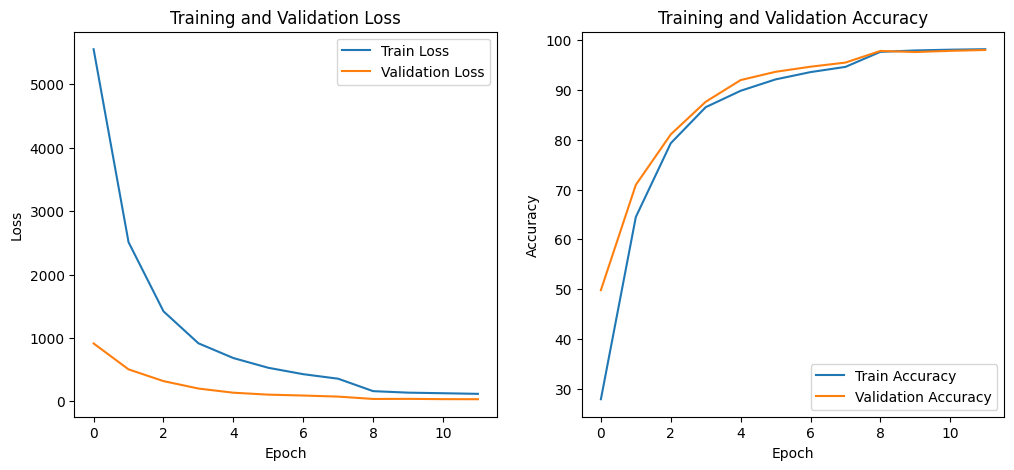

In [11]:
# Plot training and validation metrics
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [12]:
# Save the final model state dictionary
torch.save(model_vgg19.state_dict(), 'VGG19-from-scratch-with-New-Plant-Disease.pth')

In [13]:
# Loading the saved VGG19 model
import torch
from torchvision import models
import torch.nn as nn

# Load the VGG19 model architecture
model_vgg19 = models.vgg19(pretrained=False)

# Modify the classifier to match the number of classes
num_features = model_vgg19.classifier[6].in_features
model_vgg19.classifier[6] = nn.Linear(num_features, 38)

# Load the saved state dictionary
model_vgg19.load_state_dict(torch.load('VGG19-from-scratch-with-New-Plant-Disease.pth'))

# Move the model to GPU if available and set to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vgg19 = model_vgg19.to(device)
model_vgg19.eval()  # Set the model to evaluation mode


<ipython-input-13-bf8cdc3ff285>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_vgg19.load_state_dict(torch.load('VGG19-from-scratch-with-New-Plant-Disease.pth'))


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [14]:
from sklearn.metrics import classification_report
import torch
from torchvision import models
import torch.nn as nn

# VGG19
model_vgg19 = models.vgg19(pretrained=False)
model_vgg19.classifier[6] = nn.Linear(model_vgg19.classifier[6].in_features, 38)
model_vgg19.load_state_dict(torch.load('VGG19-from-scratch-with-New-Plant-Disease.pth'))
model_vgg19 = model_vgg19.to(device)
model_vgg19.eval()

vgg19_preds, vgg19_labels = get_predictions_labels(model_vgg19, valid_loader)

print("Classification Report for VGG19 Model:\n")
print(classification_report(vgg19_labels, vgg19_preds))


<ipython-input-14-1daa8d67f095>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_vgg19.load_state_dict(torch.load('VGG19-from-scratch-with-New-Plant-Disease.pth'))


Classification Report for VGG19 Model:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       504
           1       0.99      1.00      0.99       497
           2       0.99      0.98      0.98       440
           3       0.99      0.98      0.98       502
           4       0.98      0.99      0.98       454
           5       1.00      1.00      1.00       421
           6       0.97      1.00      0.98       456
           7       0.98      0.89      0.93       410
           8       0.99      1.00      0.99       477
           9       0.93      0.99      0.96       477
          10       1.00      0.99      1.00       465
          11       0.99      0.98      0.99       472
          12       0.98      1.00      0.99       480
          13       1.00      0.99      1.00       430
          14       1.00      1.00      1.00       423
          15       1.00      0.99      0.99       503
          16       0.98      0.97      0.

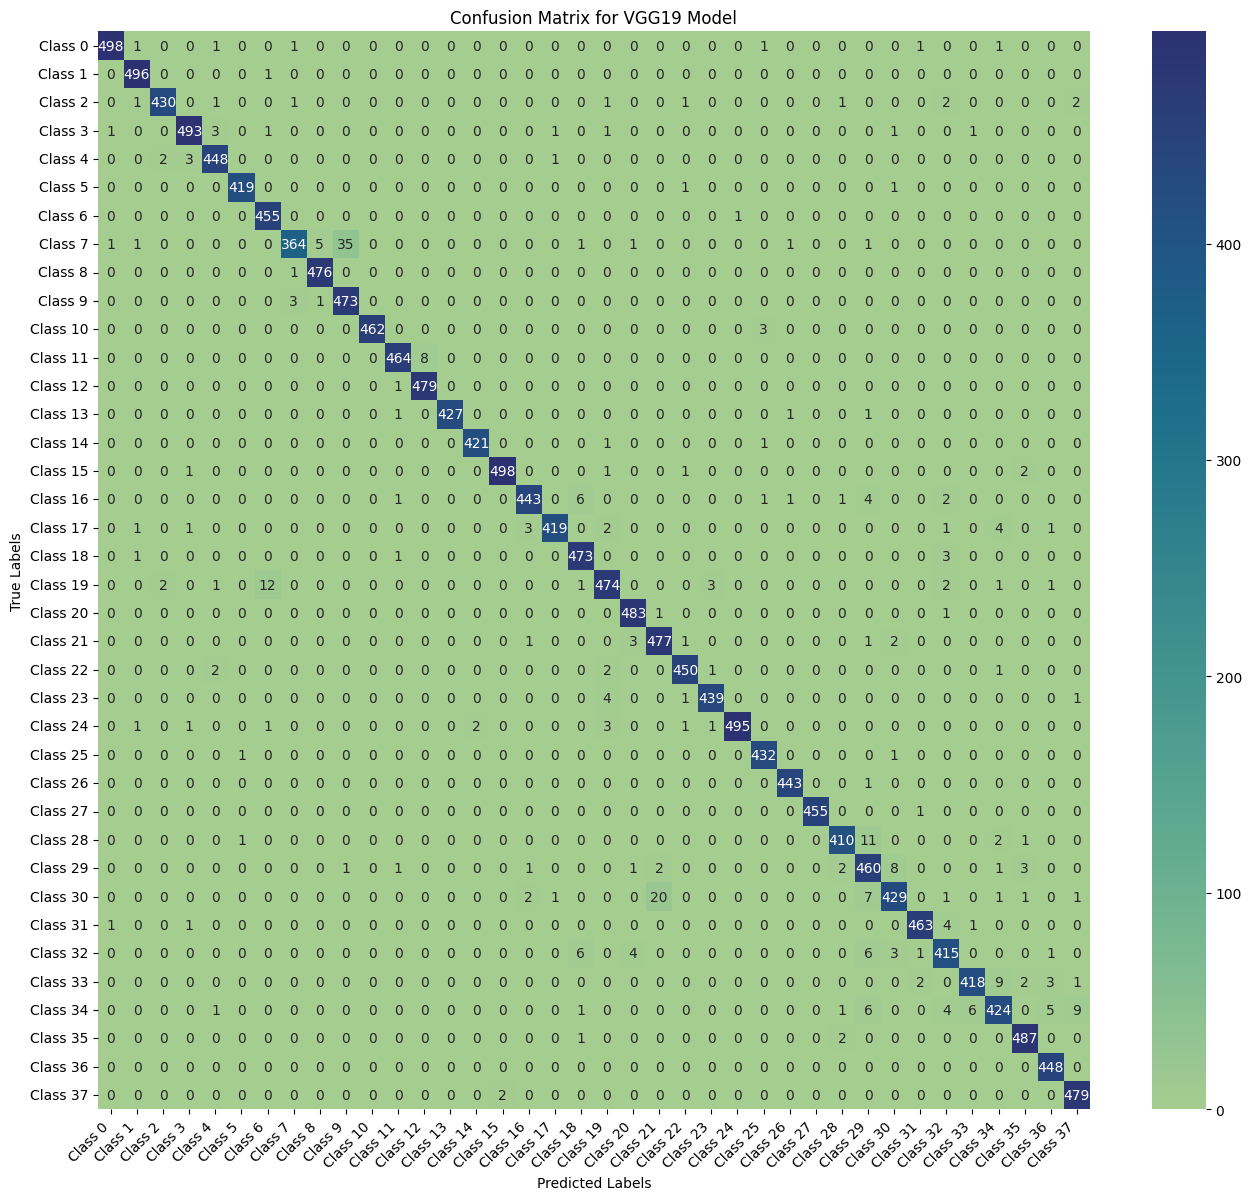

In [15]:
# Class names (replace with actual class names if you have them)
class_names = [f"Class {i}" for i in range(38)]  # Replace with actual class names if available
# Plot confusion matrix for ResNet50
plot_confusion_matrix(vgg19_labels, vgg19_preds, "VGG19", class_names)

In [16]:
import os
import torch
from PIL import Image
from sklearn.metrics import classification_report
from torchvision import transforms, models
import torch.nn as nn

# Define the correct class names in the order used during training
class_names = [
    'Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy',
    'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy',
    'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_',
    'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot',
    'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy',
    'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy',
    'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight',
    'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy',
    'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy',
    'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight',
    'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite',
    'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus',
    'Tomato___healthy'
]

# Define the mapping from simple class names to full class names in class_names
simple_to_full_class_mapping = {
    'TomatoEarlyBlight': 'Tomato___Early_blight',
    'TomatoYellowCurlVirus': 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
    'PotatoHealthy': 'Potato___healthy',
    'PotatoEarlyBlight': 'Potato___Early_blight',
    'CornCommonRust': 'Corn_(maize)___Common_rust_',
    'AppleScab': 'Apple___Apple_scab',
    'TomatoHealthy': 'Tomato___healthy',
    'AppleCedarRust': 'Apple___Cedar_apple_rust'
}

# Define the test directory path
test_dir = '/kaggle/input/new-plant-diseases-dataset/test/test'

# Define the same preprocessing transformations used during training
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard normalization for ImageNet
])

# Load the pre-trained VGG19 model with the correct output layer
model_vgg19 = models.vgg19(pretrained=False)
model_vgg19.classifier[6] = nn.Linear(model_vgg19.classifier[6].in_features, len(class_names))  # Set the output layer size
model_vgg19.load_state_dict(torch.load('/kaggle/working/Best-VGG19-from-scratch-with-New-Plant-Disease.pth'))
model_vgg19 = model_vgg19.to(device)
model_vgg19.eval()  # Set the model to evaluation mode

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Loop through each image in the test directory
for image_file in os.listdir(test_dir):
    # Extract the base class name (e.g., 'TomatoEarlyBlight' from 'TomatoEarlyBlight6.JPG')
    base_class_name = ''.join([i for i in image_file if not i.isdigit()]).replace(".JPG", "")

    # Map the simplified name to the full name in `class_names`
    true_class_name = simple_to_full_class_mapping.get(base_class_name, None)

    # Find the index in `class_names` if mapping is successful
    if true_class_name:
        true_label = class_names.index(true_class_name)
    else:
        print(f"Warning: {base_class_name} not found in class names.")
        continue  # Skip if class not found in mapping

    # Load and preprocess the image
    image_path = os.path.join(test_dir, image_file)
    image = Image.open(image_path).convert("RGB")  # Ensure the image is in RGB format
    image = test_transforms(image).unsqueeze(0).to(device)

    # Get model prediction
    with torch.no_grad():
        output = model_vgg19(image)
        _, predicted_label = torch.max(output, 1)

    # Append to results
    true_labels.append(true_label)
    predicted_labels.append(predicted_label.item())

    # Print individual predictions (optional)
    print(f"Image: {image_file} | True Label: {true_label} ({true_class_name}) | Predicted Label: {predicted_label.item()} ({class_names[predicted_label.item()]})")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-16-a226d63b62cb>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/Best-VGG19-from-scratch-with-New-Plant-Disease.pth'

In [ ]:
from sklearn.metrics import classification_report

# Find unique labels in true_labels and filter class_names accordingly
unique_labels = sorted(set(true_labels))  # Get sorted list of unique labels in the test set
filtered_class_names = [class_names[i] for i in unique_labels]  # Filter class names to match unique labels

# Generate and print the classification report
print("\nClassification Report for Test Set:\n")
print(classification_report(true_labels, predicted_labels, labels=unique_labels, target_names=filtered_class_names))